In [1]:
text ='Next character prediction is a fundamental task in the field of natural language processing (NLP) that involves predicting the next character in a sequence of text based on the characters that precede it. This task is essential for various applications, including text auto-completion, spell checking, and even in the development of sophisticated AI models capable of generating human-like text. At its core, next character prediction relies on statistical models or deep learning algorithms to analyze a given sequence of text and predict which character is most likely to follow. These predictions are based on patterns and relationships learned from large datasets of text during the training phase of the model. One of the most popular approaches to next character prediction involves the use of Recurrent Neural Networks (RNNs), and more specifically, a variant called Long Short-Term Memory (LSTM) networks. RNNs are particularly well-suited for sequential data like text, as they can maintain information in "memory" about previous characters to inform the prediction of the next character. LSTM networks enhance this capability by being able to remember long-term dependencies, making them even more effective for next character prediction tasks. Training a model for next character prediction involves feeding it large amounts of text data, allowing it to learn the probability of each characters appearance following a sequence of characters. During this training process, the model adjusts its parameters to minimize the difference between its predictions and the actual outcomes, thus improving its predictive accuracy over time. Once trained, the model can be used to predict the next character in a given piece of text by considering the sequence of characters that precede it. This can enhance user experience in text editing software, improve efficiency in coding environments with auto-completion features, and enable more natural interactions with AI-based chatbots and virtual assistants. In summary, next character prediction plays a crucial role in enhancing the capabilities of various NLP applications, making text-based interactions more efficient, accurate, and human-like. Through the use of advanced machine learning models like RNNs and LSTMs, next character prediction continues to evolve, opening new possibilities for the future of text-based technology.'

Training with sequence length: 10


C:\Users\SirM\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch: 1, Train Loss: 2.9907, Train Accuracy: 0.1716, Val Loss: 2.6809, Val Accuracy: 0.2308, Duration: 0.95s
Epoch: 2, Train Loss: 2.6344, Train Accuracy: 0.2304, Val Loss: 2.5874, Val Accuracy: 0.2545, Duration: 0.80s
Epoch: 3, Train Loss: 2.5342, Train Accuracy: 0.2378, Val Loss: 2.4521, Val Accuracy: 0.2632, Duration: 0.77s
Epoch: 4, Train Loss: 2.4795, Train Accuracy: 0.2459, Val Loss: 2.3819, Val Accuracy: 0.2375, Duration: 0.83s
Epoch: 5, Train Loss: 2.4245, Train Accuracy: 0.2522, Val Loss: 2.3378, Val Accuracy: 0.2739, Duration: 0.77s
Epoch: 6, Train Loss: 2.3938, Train Accuracy: 0.2588, Val Loss: 2.3234, Val Accuracy: 0.2843, Duration: 0.82s
Epoch: 7, Train Loss: 2.3602, Train Accuracy: 0.2720, Val Loss: 2.3055, Val Accuracy: 0.2608, Duration: 0.86s
Epoch: 8, Train Loss: 2.3622, Train Accuracy: 0.2603, Val Loss: 2.2853, Val Accuracy: 0.2826, Duration: 0.76s
Epoch: 9, Train Loss: 2.3329, Train Accuracy: 0.2595, Val Loss: 2.2654, Val Accuracy: 0.2707, Duration: 0.78s
Epoch: 10,

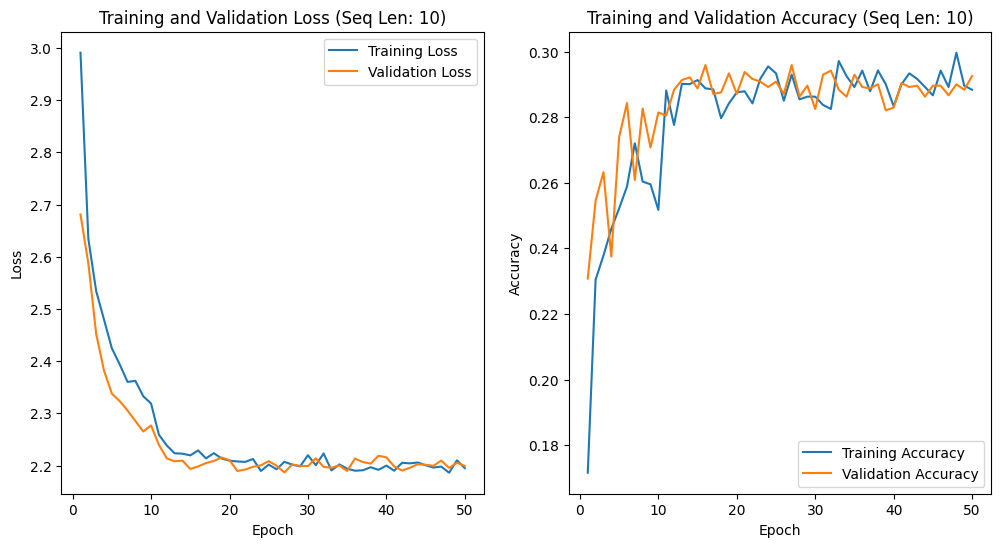

Training with sequence length: 20


C:\Users\SirM\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch: 1, Train Loss: 3.1202, Train Accuracy: 0.1345, Val Loss: 2.8986, Val Accuracy: 0.2321, Duration: 0.92s
Epoch: 2, Train Loss: 2.7393, Train Accuracy: 0.2195, Val Loss: 2.5627, Val Accuracy: 0.2528, Duration: 0.88s
Epoch: 3, Train Loss: 2.5837, Train Accuracy: 0.2478, Val Loss: 2.5507, Val Accuracy: 0.2359, Duration: 0.88s
Epoch: 4, Train Loss: 2.5244, Train Accuracy: 0.2389, Val Loss: 2.4330, Val Accuracy: 0.2630, Duration: 0.88s
Epoch: 5, Train Loss: 2.4592, Train Accuracy: 0.2537, Val Loss: 2.3775, Val Accuracy: 0.2609, Duration: 0.88s
Epoch: 6, Train Loss: 2.4281, Train Accuracy: 0.2477, Val Loss: 2.3347, Val Accuracy: 0.2694, Duration: 0.89s
Epoch: 7, Train Loss: 2.4017, Train Accuracy: 0.2524, Val Loss: 2.3379, Val Accuracy: 0.2516, Duration: 0.88s
Epoch: 8, Train Loss: 2.3743, Train Accuracy: 0.2612, Val Loss: 2.3074, Val Accuracy: 0.2744, Duration: 0.87s
Epoch: 9, Train Loss: 2.3462, Train Accuracy: 0.2621, Val Loss: 2.2874, Val Accuracy: 0.2727, Duration: 0.87s
Epoch: 10,

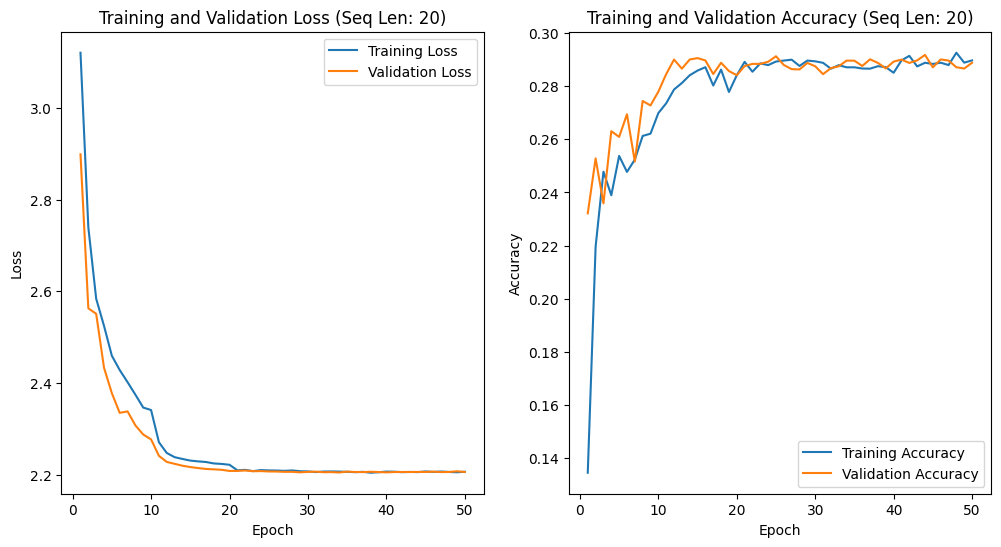

Training with sequence length: 30
Epoch: 1, Train Loss: 3.1211, Train Accuracy: 0.1257, Val Loss: 2.8070, Val Accuracy: 0.1863, Duration: 1.19s
Epoch: 2, Train Loss: 2.7496, Train Accuracy: 0.2301, Val Loss: 2.5965, Val Accuracy: 0.2456, Duration: 1.19s
Epoch: 3, Train Loss: 2.6076, Train Accuracy: 0.2432, Val Loss: 2.5253, Val Accuracy: 0.2699, Duration: 1.19s
Epoch: 4, Train Loss: 2.5351, Train Accuracy: 0.2306, Val Loss: 2.4441, Val Accuracy: 0.2585, Duration: 1.19s
Epoch: 5, Train Loss: 2.4607, Train Accuracy: 0.2471, Val Loss: 2.3900, Val Accuracy: 0.2618, Duration: 1.19s
Epoch: 6, Train Loss: 2.4437, Train Accuracy: 0.2495, Val Loss: 2.3426, Val Accuracy: 0.2593, Duration: 1.19s
Epoch: 7, Train Loss: 2.3905, Train Accuracy: 0.2470, Val Loss: 2.3296, Val Accuracy: 0.2722, Duration: 1.18s
Epoch: 8, Train Loss: 2.3853, Train Accuracy: 0.2582, Val Loss: 2.3256, Val Accuracy: 0.2778, Duration: 1.19s
Epoch: 9, Train Loss: 2.3610, Train Accuracy: 0.2609, Val Loss: 2.2861, Val Accuracy: 

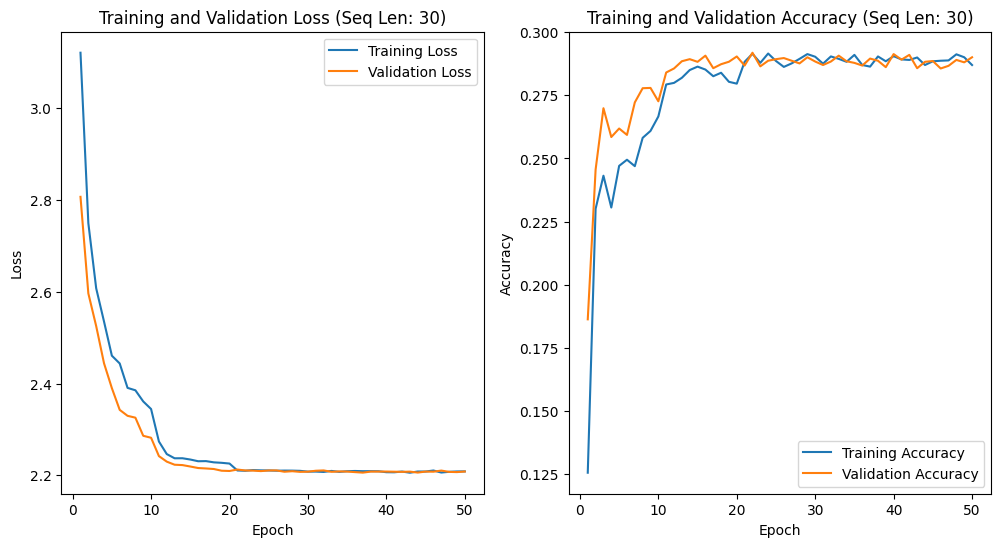

Overall accuracy for sequence length 10: 0.2925
Overall accuracy for sequence length 20: 0.2888
Overall accuracy for sequence length 30: 0.2900


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import time
import matplotlib.pyplot as plt

# Create character mapping
chars = sorted(set(text))
char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

# Helper function to create input and target sequences
def create_sequences(text, seq_length):
    inputs = []
    targets = []
    for i in range(len(text) - seq_length):
        input_seq = text[i:i + seq_length]
        target_char = text[i + seq_length]
        inputs.append([char_to_ix[ch] for ch in input_seq])
        targets.append(char_to_ix[target_char])
    return torch.tensor(inputs, dtype=torch.long), torch.tensor(targets, dtype=torch.long)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

# Incorporate Positional Encoding in CharTransformer
class CharTransformer(nn.Module):
    def __init__(self, vocab_size, hidden_size, nhead, num_layers, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size  # Store hidden_size as an instance variable
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.pos_encoder = PositionalEncoding(hidden_size)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_size, nhead=nhead, dropout=dropout),
            num_layers)
        self.fc_out = nn.Linear(hidden_size, vocab_size)

    def forward(self, src):
        embedded = self.embedding(src) * np.sqrt(self.hidden_size)  # Use self.hidden_size here
        embedded = self.pos_encoder(embedded)
        transformer_output = self.transformer_encoder(embedded)
        return self.fc_out(transformer_output[:, -1])

# Training and evaluation function
def train_and_evaluate(model, data_loader, criterion, optimizer, scheduler, device, clip):
    model.to(device)
    model.train()
    total_loss = 0
    total_accuracy = 0  # Track total accuracy
    start_time = time.time()

    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        # Gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
        optimizer.step()
        total_loss += loss.item()
        total_accuracy += (output.argmax(1) == targets).float().mean().item()

    # Adjust the learning rate
    scheduler.step()
    duration = time.time() - start_time
    total_accuracy /= len(data_loader)  # Calculate mean accuracy over all batches

    # Validation
    model.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs)
            val_loss += criterion(output, targets).item()
            val_accuracy += (output.argmax(1) == targets).float().mean().item()

    val_loss /= len(data_loader)
    val_accuracy /= len(data_loader)
    return total_loss / len(data_loader), total_accuracy, val_loss, val_accuracy, duration

# Prepare data for different sequence lengths
sequence_lengths = [10, 20, 30]
results = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train and validate for each sequence length
for seq_length in sequence_lengths:
    print(f"Training with sequence length: {seq_length}")
    inputs, targets = create_sequences(text, seq_length)
    dataset = TensorDataset(inputs, targets)
    data_loader = DataLoader(dataset, batch_size=64, shuffle=True)
    
    model = CharTransformer(len(chars), 256, 8, 6, dropout=0.001)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    clip = 1.0  # Gradient clipping

    epochs = 50
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(epochs):
        train_loss, train_accuracy, val_loss, val_accuracy, duration = train_and_evaluate(
            model, data_loader, criterion, optimizer, scheduler, device, clip)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        print(f"Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Duration: {duration:.2f}s")

    results[seq_length] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

    # Plotting training and validation metrics
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
    plt.title(f'Training and Validation Loss (Seq Len: {seq_length})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy (Seq Len: {seq_length})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Print overall accuracy for each sequence length
for seq_length in sequence_lengths:
    print(f"Overall accuracy for sequence length {seq_length}: "
          f"{results[seq_length]['val_accuracies'][-1]:.4f}")


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import requests
import time
import math
import numpy as np

# Download the dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text

# Character mapping to integers
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}
vocab_size = len(chars)

# Dataset class
class CharDataset(Dataset):
    def __init__(self, text, seq_length):
        self.text = text
        self.seq_length = seq_length
        self.char_to_int = char_to_int

    def __len__(self):
        return len(self.text) - self.seq_length

    def __getitem__(self, index):
        seq = self.text[index:index+self.seq_length]
        target = self.text[index+self.seq_length]
        return (torch.tensor([self.char_to_int[ch] for ch in seq], dtype=torch.long),
                torch.tensor(self.char_to_int[target], dtype=torch.long))

# Transformer Model class
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, hidden_dim, nhead, num_layers, dropout):
        super(TransformerModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.pos_encoder = nn.Embedding(5000, hidden_dim)  # Positional encoding for up to 5000 positions
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, dropout=dropout),
            num_layers=num_layers)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, src, mask):
        src = self.embedding(src) * math.sqrt(self.hidden_dim)
        src = src + self.pos_encoder(torch.arange(0, src.size(1)).unsqueeze(0).to(src.device))
        output = self.transformer(src, mask=mask)  # Corrected the argument name here
        return self.fc_out(output)

# Function to generate a square mask for sequence masking
def generate_square_subsequent_mask(sz, batch_size):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask.expand(batch_size, -1, -1)  # Expand the mask to cover the full batch

def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs, device):
    for epoch in range(epochs):
        # Training
        model.train()
        total_train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            mask = generate_square_subsequent_mask(data.size(1)).to(device)
            output = model(data, mask)
            loss = criterion(output.view(-1, vocab_size), target.view(-1))
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_loader):
                data, target = data.to(device), target.to(device)
                mask = generate_square_subsequent_mask(data.size(1)).to(device)
                output = model(data, mask)
                loss = criterion(output.view(-1, vocab_size), target.view(-1))
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)

        print(f'Epoch: {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    return model, avg_train_loss, avg_val_loss

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Hyperparameters to tune
    sequence_lengths = [20, 30, 50]
    hidden_dims = [256, 512]
    num_heads = [4, 8]
    num_layers_options = [3, 4]
    dropout_rates = [0.1, 0.2]
    learning_rate = 0.001
    epochs = 10 

    for seq_len in sequence_lengths:
        dataset = CharDataset(text, seq_len)
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
        
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
        
        for hidden_dim in hidden_dims:
            for num_head in num_heads:
                for num_layer in num_layers_options:
                    for dropout_rate in dropout_rates:
                        model = TransformerModel(vocab_size, hidden_dim, num_head, num_layer, dropout_rate).to(device)
                        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
                        criterion = nn.CrossEntropyLoss()
                        
                        print(f'Training with seq_len: {seq_len}, hidden_dim: {hidden_dim}, '
                              f'num_head: {num_head}, num_layer: {num_layer}, dropout_rate: {dropout_rate}')
                        
                        trained_model, train_loss, val_loss = train_and_validate(
                            model, train_loader, val_loader, optimizer, criterion, epochs, device)
                        
                        print(f'Seq_len: {seq_len}, Hidden_dim: {hidden_dim}, Num_heads: {num_head}, '
                              f'Num_layers: {num_layer}, Dropout: {dropout_rate}, '
                              f'Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}')
        
    # epoch_train_losses = []
    # epoch_val_losses = []
    # epoch_train_accuracies = []
    # epoch_val_accuracies = []
    # 
    # for epoch in range(epochs):
    #     train_loss, val_loss, train_accuracy, val_accuracy, _ = train_and_validate(
    #         model, train_loader, val_loader, optimizer, criterion, epochs, device
    #     )
    # 
    #         # Store metrics
    #     epoch_train_losses.append(train_loss)
    #     epoch_val_losses.append(val_loss)
    #     epoch_train_accuracies.append(train_accuracy)
    #     epoch_val_accuracies.append(val_accuracy)
    # 
    #     # Overall accuracy across all epochs
    # overall_train_accuracy = np.mean(epoch_train_accuracies)
    # overall_val_accuracy = np.mean(epoch_val_accuracies)

    # # Display overall accuracies
    # print(f"Overall training accuracy for sequence length {seq_len}: {overall_train_accuracy:.4f}")
    # print(f"Overall validation accuracy for sequence length {seq_len}: {overall_val_accuracy:.4f}")
    # 
    # # Plot training vs validation loss
    # plt.figure(figsize=(10, 4))
    # plt.subplot(1, 2, 1)
    # plt.plot(epoch_train_losses, label='Training Loss')
    # plt.plot(epoch_val_losses, label='Validation Loss')
    # plt.title(f'Training and Validation Loss (Seq Len: {seq_len})')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.legend()
    # 
    # # Plot training vs validation accuracy
    # plt.subplot(1, 2, 2)
    # plt.plot(epoch_train_accuracies, label='Training Accuracy')
    # plt.plot(epoch_val_accuracies, label='Validation Accuracy')
    # plt.title(f'Training and Validation Accuracy (Seq Len: {seq_len})')
    # plt.xlabel('Epoch')
    # plt.ylabel('Accuracy')
    # plt.legend()
    # plt.show()
        
if __name__ == '__main__':
    main() 

C:\Users\SirM\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Training with seq_len: 20, hidden_dim: 256, num_head: 4, num_layer: 3, dropout_rate: 0.1


TypeError: generate_square_subsequent_mask() missing 1 required positional argument: 'batch_size'

In [1]:
english_to_french = [

    ("I am cold", "J'ai froid"),

    ("You are tired", "Tu es fatigué"),

    ("He is hungry", "Il a faim"),

    ("She is happy", "Elle est heureuse"),

    ("We are friends", "Nous sommes amis"),

    ("They are students", "Ils sont étudiants"),

    ("The cat is sleeping", "Le chat dort"),

    ("The sun is shining", "Le soleil brille"),

    ("We love music", "Nous aimons la musique"),

    ("She speaks French fluently", "Elle parle français couramment"),

    ("He enjoys reading books", "Il aime lire des livres"),

    ("They play soccer every weekend", "Ils jouent au football chaque week-end"),

    ("The movie starts at 7 PM", "Le film commence à 19 heures"),

    ("She wears a red dress", "Elle porte une robe rouge"),

    ("We cook dinner together", "Nous cuisinons le dîner ensemble"),

    ("He drives a blue car", "Il conduit une voiture bleue"),

    ("They visit museums often", "Ils visitent souvent des musées"),

    ("The restaurant serves delicious food", "Le restaurant sert une délicieuse cuisine"),

    ("She studies mathematics at university", "Elle étudie les mathématiques à l'université"),

    ("We watch movies on Fridays", "Nous regardons des films le vendredi"),

    ("He listens to music while jogging", "Il écoute de la musique en faisant du jogging"),

    ("They travel around the world", "Ils voyagent autour du monde"),

    ("The book is on the table", "Le livre est sur la table"),

    ("She dances gracefully", "Elle danse avec grâce"),

    ("We celebrate birthdays with cake", "Nous célébrons les anniversaires avec un gâteau"),

    ("He works hard every day", "Il travaille dur tous les jours"),

    ("They speak different languages", "Ils parlent différentes langues"),

    ("The flowers bloom in spring", "Les fleurs fleurissent au printemps"),

    ("She writes poetry in her free time", "Elle écrit de la poésie pendant son temps libre"),

    ("We learn something new every day", "Nous apprenons quelque chose de nouveau chaque jour"),

    ("The dog barks loudly", "Le chien aboie bruyamment"),

    ("He sings beautifully", "Il chante magnifiquement"),

    ("They swim in the pool", "Ils nagent dans la piscine"),

    ("The birds chirp in the morning", "Les oiseaux gazouillent le matin"),

    ("She teaches English at school", "Elle enseigne l'anglais à l'école"),

    ("We eat breakfast together", "Nous prenons le petit déjeuner ensemble"),

    ("He paints landscapes", "Il peint des paysages"),

    ("They laugh at the joke", "Ils rient de la blague"),

    ("The clock ticks loudly", "L'horloge tic-tac bruyamment"),

    ("She runs in the park", "Elle court dans le parc"),

    ("We travel by train", "Nous voyageons en train"),

    ("He writes a letter", "Il écrit une lettre"),

    ("They read books at the library", "Ils lisent des livres à la bibliothèque"),

    ("The baby cries", "Le bébé pleure"),

    ("She studies hard for exams", "Elle étudie dur pour les examens"),

    ("We plant flowers in the garden", "Nous plantons des fleurs dans le jardin"),

    ("He fixes the car", "Il répare la voiture"),

    ("They drink coffee in the morning", "Ils boivent du café le matin"),

    ("The sun sets in the evening", "Le soleil se couche le soir"),

    ("She dances at the party", "Elle danse à la fête"),

    ("We play music at the concert", "Nous jouons de la musique au concert"),

    ("He cooks dinner for his family", "Il cuisine le dîner pour sa famille"),

    ("They study French grammar", "Ils étudient la grammaire française"),

    ("The rain falls gently", "La pluie tombe doucement"),

    ("She sings a song", "Elle chante une chanson"),

    ("We watch a movie together", "Nous regardons un film ensemble"),

    ("He sleeps deeply", "Il dort profondément"),

    ("They travel to Paris", "Ils voyagent à Paris"),

    ("The children play in the park", "Les enfants jouent dans le parc"),

    ("She walks along the beach", "Elle se promène le long de la plage"),

    ("We talk on the phone", "Nous parlons au téléphone"),

    ("He waits for the bus", "Il attend le bus"),

    ("They visit the Eiffel Tower", "Ils visitent la tour Eiffel"),

    ("The stars twinkle at night", "Les étoiles scintillent la nuit"),

    ("She dreams of flying", "Elle rêve de voler"),

    ("We work in the office", "Nous travaillons au bureau"),

    ("He studies history", "Il étudie l'histoire"),

    ("They listen to the radio", "Ils écoutent la radio"),

    ("The wind blows gently", "Le vent souffle doucement"),

    ("She swims in the ocean", "Elle nage dans l'océan"),

    ("We dance at the wedding", "Nous dansons au mariage"),

    ("He climbs the mountain", "Il gravit la montagne"),

    ("They hike in the forest", "Ils font de la randonnée dans la forêt"),

    ("The cat meows loudly", "Le chat miaule bruyamment"),

    ("She paints a picture", "Elle peint un tableau"),

    ("We build a sandcastle", "Nous construisons un château de sable"),

    ("He sings in the choir", "Il chante dans le chœur")

]

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import math
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Constants
MAX_LENGTH = 10  # Assuming the maximum length of sentences
SOS_token = 1    # Start-of-sentence token index
EOS_token = 2    # End-of-sentence token index
EMBED_SIZE = 100  # Size of the embedding vector

class Vocabulary:
    def __init__(self):
        self.word2index = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2}
        self.index2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>"}
        self.word_count = {}
        self.n_words = 3  # Start counting from 3 to account for special tokens

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.word_count[word] = 1
            self.n_words += 1

def tokenize_and_pad(sentences, vocab, max_length):
    tokenized_sentences = []
    for sentence in sentences:
        tokens = [vocab.word2index["<SOS>"]] + [vocab.word2index.get(word, 0) for word in sentence.split(' ')] + [vocab.word2index["<EOS>"]]
        padded_tokens = tokens + [vocab.word2index["<PAD>"]] * (max_length - len(tokens))
        tokenized_sentences.append(padded_tokens)
    return torch.tensor(tokenized_sentences, dtype=torch.long)

class EngFrDataset(Dataset):
    def __init__(self, pairs):
        self.eng_vocab = Vocabulary()
        self.fr_vocab = Vocabulary()
        for eng, fr in pairs:
            self.eng_vocab.add_sentence(eng)
            self.fr_vocab.add_sentence(fr)
        self.pairs = [(eng, fr) for eng, fr in pairs]

        # Find the maximum length from both languages
        max_length = max(
            max(len(eng.split(' ')) for eng, _ in pairs),
            max(len(fr.split(' ')) for _, fr in pairs)
        ) + 2  # Account for SOS and EOS tokens

        self.eng_tokens = tokenize_and_pad([eng for eng, _ in self.pairs], self.eng_vocab, max_length)
        self.fr_tokens = tokenize_and_pad([fr for _, fr in self.pairs], self.fr_vocab, max_length)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return self.eng_tokens[idx], self.fr_tokens[idx]

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, embed_size, nhead, ff_dim, num_layers):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embed_size)
        self.pos_encoder = PositionalEncoding(embed_size)
        self.transformer = nn.Transformer(d_model=embed_size, nhead=nhead, 
                                          num_encoder_layers=num_layers, 
                                          num_decoder_layers=num_layers,
                                          dim_feedforward=ff_dim, batch_first=True)
        self.fc_out = nn.Linear(embed_size, output_dim)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_key_padding_mask=None, tgt_key_padding_mask=None):
        src = self.embedding(src) * math.sqrt(EMBED_SIZE)
        tgt = self.embedding(tgt) * math.sqrt(EMBED_SIZE)
        src = self.pos_encoder(src)
        tgt = self.pos_encoder(tgt)
        output = self.transformer(src, tgt, src_mask=src_mask, tgt_mask=tgt_mask,
                                  src_key_padding_mask=src_key_padding_mask, tgt_key_padding_mask=tgt_key_padding_mask)
        output = self.fc_out(output)
        return output

    @staticmethod
    def generate_square_subsequent_mask(sz):
        mask = torch.triu(torch.ones(sz, sz)).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

# Initialize the dataset and DataLoader
dataset = EngFrDataset(english_to_french)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Initialize model
transformer_model = TransformerModel(dataset.eng_vocab.n_words, dataset.fr_vocab.n_words, EMBED_SIZE, 4, 200, 2).to(device)

# Define loss function and optimizer
loss_function = nn.CrossEntropyLoss(ignore_index=dataset.eng_vocab.word2index["<PAD>"])
optimizer = optim.Adam(transformer_model.parameters(), lr=0.001)

# Training and Evaluation functions
def train(model, dataloader, optimizer, loss_function, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)

            src_mask = TransformerModel.generate_square_subsequent_mask(src.size(1)).to(device)
            tgt_mask = TransformerModel.generate_square_subsequent_mask(tgt.size(1) - 1).to(device)  # Adjusting for tgt[:, :-1]
            
            src_pad_mask = (src == dataset.eng_vocab.word2index["<PAD>"]).transpose(0, 1).to(device)
            tgt_pad_mask = (tgt == dataset.fr_vocab.word2index["<PAD>"]).transpose(0, 1).to(device)

            optimizer.zero_grad()
            output = model(src, tgt[:, :-1],
                           src_mask=src_mask, tgt_mask=tgt_mask,
                           src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=tgt_pad_mask[:, :-1])
            loss = loss_function(output.reshape(-1, output.shape[-1]), tgt[:, 1:].reshape(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}')

# Call the training function
train(transformer_model, dataloader, optimizer, loss_function, num_epochs=10)

if __name__ == "__main__":
    # Load dataset
    dataset = EngFrDataset(english_to_french)
    print("English Vocabulary Size:", dataset.eng_vocab.n_words)
    print("French Vocabulary Size:", dataset.fr_vocab.n_words)

    # Initialize model and move to device step-by-step
    try:
        transformer_model = TransformerModel(dataset.eng_vocab.n_words, dataset.fr_vocab.n_words, EMBED_SIZE, 4, 200, 2)
        transformer_model.to(device)  # Now move the entire model
    except RuntimeError as e:
        print("Failed to move model to GPU:", e)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
